In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import datetime
import numpy as np
import torch
import torch.nn.functional as F

torch.autograd.set_detect_anomaly(True)
# torch.set_default_dtype(torch.float32)

import mediapy as mpy
from tqdm.auto import tqdm
from IPython.display import clear_output, display
import matplotlib.pyplot as plt
import wandb

from nca_model import NCAModel, SimpleNCA
from pool import NCAPool
from utils import nca_out_to_vids, tonp, save_model, load_latest_model, nca_cmap, pad_to
from data import (
    MNISTPatternGenerator,
    MNISTPatternPool,
    generate_radial_circles_pattern,
    generate_canonical_mnist_digits,
)

In [3]:
device = "cuda"
num_classes = 10
channs = 16
bs = 16
S = 80
lr = 0.0008
pool_size = 64
pool_replacement = 0.7

In [5]:
from torchvision.datasets.cifar import CIFAR10

In [9]:
ds = CIFAR10("/home/iz/.cache/", download=True)

Files already downloaded and verified


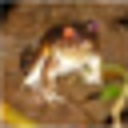

In [15]:
ds[0][0].resize((128, 128))

In [4]:
nca = SimpleNCA(channs).to(device)

In [5]:
inp = torch.rand(5, channs, S, S).to(device)
out = nca(inp, steps=50)
len(out), out[0].shape

(51, torch.Size([5, 16, 80, 80]))

,,,,

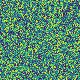
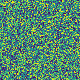
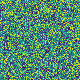
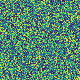
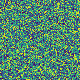

In [6]:
nca_out_to_vids(out)

,,,,,,,,,

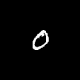
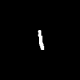
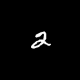
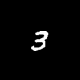
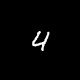
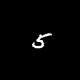
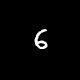
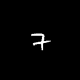
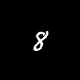
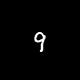

In [7]:
canonical_mnist_digits = generate_canonical_mnist_digits()
canonical_mnist_digits = pad_to(canonical_mnist_digits, S)

mpy.show_images(canonical_mnist_digits, width=100)

In [8]:
pool = MNISTPatternPool(
    is_train=True, channs=channs, size=S, pool_size=pool_size, pattern=canonical_mnist_digits,
    replacement=pool_replacement
)
sample = pool.sample(bs=bs)
inp = sample.batch["inp"][:, 0]
out = sample.batch["out"]

,,,,,,,,,,,,,,,

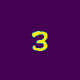
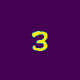
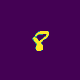
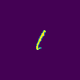
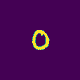
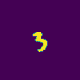
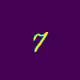
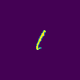
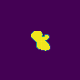
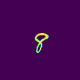
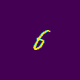
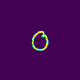
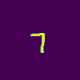
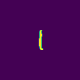
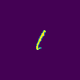
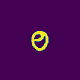

In [9]:
mpy.show_images(inp, cmap="viridis", width=100)

,,,,,,,,,,,,,,,

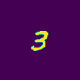
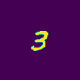
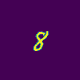
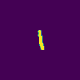
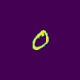
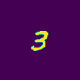
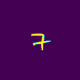
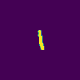
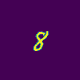
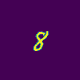
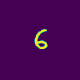
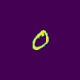
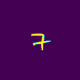
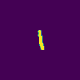
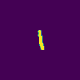
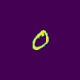

In [10]:
mpy.show_images(out, cmap="viridis", width=100)

In [11]:
nca = SimpleNCA(channs).to(device)

In [18]:
train_gen = MNISTPatternPool(
    is_train=True, channs=channs, size=S, pool_size=pool_size, pattern=canonical_mnist_digits,
    replacement=pool_replacement
)

optim = torch.optim.Adam(nca.parameters(), lr=lr)
history = []

In [20]:
os.environ["WANDB_NOTEBOOK_NAME"] = "./train.ipynb"

run = wandb.init(
    project="nca-classifier",
    name="nca-80-canon",
    save_code=True,
)
_ = run.log_code(
    "./",
    include_fn=lambda path: path.endswith(".py") or path.endswith(".ipynb"),
)

wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find ./train.ipynb.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ichko to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Loss: 0.0039622411:  13%|#3        | 3300/25000 [21:27<2:14:39,  2.69it/s]

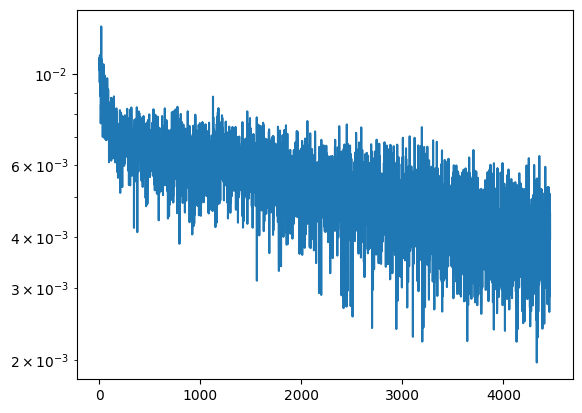

,,,,,,,
,,,,,,,

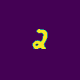
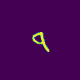
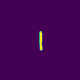
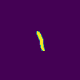
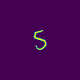
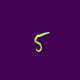
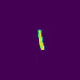
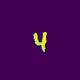
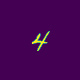
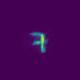
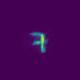
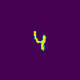
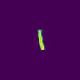
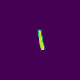
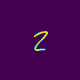
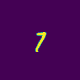

In [ ]:
pbar = tqdm(range(25_000))

for i in pbar:
    sample = train_gen.sample(bs)
    inp, out_gt = sample.batch["inp"], sample.batch["out"]
    out_gt = out_gt.to(device)

    steps = np.random.randint(30, 80)
    out_pred = nca(inp.to(device), steps=steps)
    last_step = out_pred[-1]
    last_frame = last_step[:, 0]

    losses = F.mse_loss(last_frame, out_gt, reduction="none")
    losses = losses.reshape(bs, -1).mean(axis=1)
    loss = losses.mean()

    train_gen.update(sample, last_step, losses)

    optim.zero_grad()
    loss.backward()
    optim.step()

    pbar.set_description(f"Loss: {loss:.10f}")
    run.log({"loss": loss.item()})

    history.append(loss.item())

    if i % 150 == 0:
        clear_output()
        display(pbar.container)
        
        plt.plot(history)
        plt.yscale("log")
        plt.show()
        
        with torch.inference_mode():
            out_pred = nca(inp.to(device), steps=50)
            nca_out_to_vids(out_pred, columns=8)

            run.log({"train_example": [
                wandb.Video(v, fps=20) for v in nca_cmap(out_pred)
            ]})

In [ ]:
save_path = save_model(nca, ".checkpoints/nca-{now}.pkl")
wandb.save(save_path)

In [ ]:
run.finish()

In [ ]:
with torch.no_grad():
    inp, out_gt = next(test_gen)
    out_pred = nca(inp.to(device), steps=500)
    nca_out_to_vids(out_pred, columns=8)

In [ ]:
# nca_loaded = load_latest_model(".checkpoints/")